In [389]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import cv2
import json
import matplotlib.cm as cm
import tensorflow.keras.backend as K
import torch
import shutil
import streamlit as st
from tqdm import tqdm
from torchvision import models, transforms
from PIL import Image
from ultralytics import YOLO
from roboflow import Roboflow
from collections import Counter
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import VGG16, EfficientNetB3, ResNet50, VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, RandomFlip, RandomRotation, RandomZoom, RandomContrast, GlobalAveragePooling2D, BatchNormalization, Lambda,UpSampling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from collections import Counter
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from collections import defaultdict

In [393]:
##configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
save_dir = '/Users/hadleygriffin/Desktop/GRAD SCHOOL/MSDS498'
train_dir = '/Users/hadleygriffin/MSDS 458/wiki-art-2/train'
valid_dir = '/Users/hadleygriffin/MSDS 458/wiki-art-2/valid'
test_dir = '/Users/hadleygriffin/MSDS 458/wiki-art-2/test'

In [124]:
##helper function - extract artist name
def extract_artist_from_filename(filename):
    """
    Extracts artist name from a filename like:
    'sandro-botticelli_the-virgin-adoring-the-child-1-1-_jpg.rf.deda3e...'
    """
    return filename.split("_")[0]

In [125]:
##helper function - labels 
def extract_artist_labels_from(directory, genre_classes):
    return set(
        extract_artist_from_filename(f)
        for g in genre_classes
        for f in os.listdir(os.path.join(directory, g))
        if f.endswith(('.jpg', '.png'))
    )

In [126]:
##train class discovery 
train_genre_classes = sorted([d for d in os.listdir(train_dir) if not d.startswith('.')])
train_artist_classes = sorted(list(extract_artist_labels_from(train_dir, train_genre_classes).union(extract_artist_labels_from(train_dir, train_genre_classes))))

In [127]:
##valid class discovery 
valid_genre_classes = sorted([d for d in os.listdir(valid_dir) if not d.startswith('.')])
valid_artist_classes = sorted(list(extract_artist_labels_from(valid_dir, valid_genre_classes).union(extract_artist_labels_from(valid_dir, valid_genre_classes))))

In [128]:
##test class discovry 
test_genre_classes = sorted([d for d in os.listdir(test_dir) if not d.startswith('.')])
test_artist_classes = sorted(list(extract_artist_labels_from(test_dir, test_genre_classes).union(extract_artist_labels_from(test_dir, test_genre_classes))))

In [129]:
##Count labels 
genre_counts = Counter()
artist_counts = Counter()
for genre in test_genre_classes:
    genre_path = os.path.join(train_dir, genre)
    for filename in os.listdir(genre_path):
        if filename.endswith(('.jpg', '.png')):
            genre_counts[genre] += 1
            artist = '_'.join(filename.split('_')[:-2])
            artist_counts[artist] += 1

In [130]:
top_genres_df = pd.DataFrame(genre_counts.most_common(20), columns = ['Genre', 'Count'])
top_artists_df = pd.DataFrame(artist_counts.most_common(20), columns = ['Artist', 'Count'])
top_50_artists = [artist for artist, _ in artist_counts.most_common(50)]
top_50_genres = [genre for genre, _ in genre_counts.most_common(50)]
top_artist_classes = sorted(top_50_artists)
top_genre_classes = sorted(top_50_genres)
top_NUM_ARTISTS = len(top_artist_classes)
top_NUM_GENRES = len(top_genre_classes)

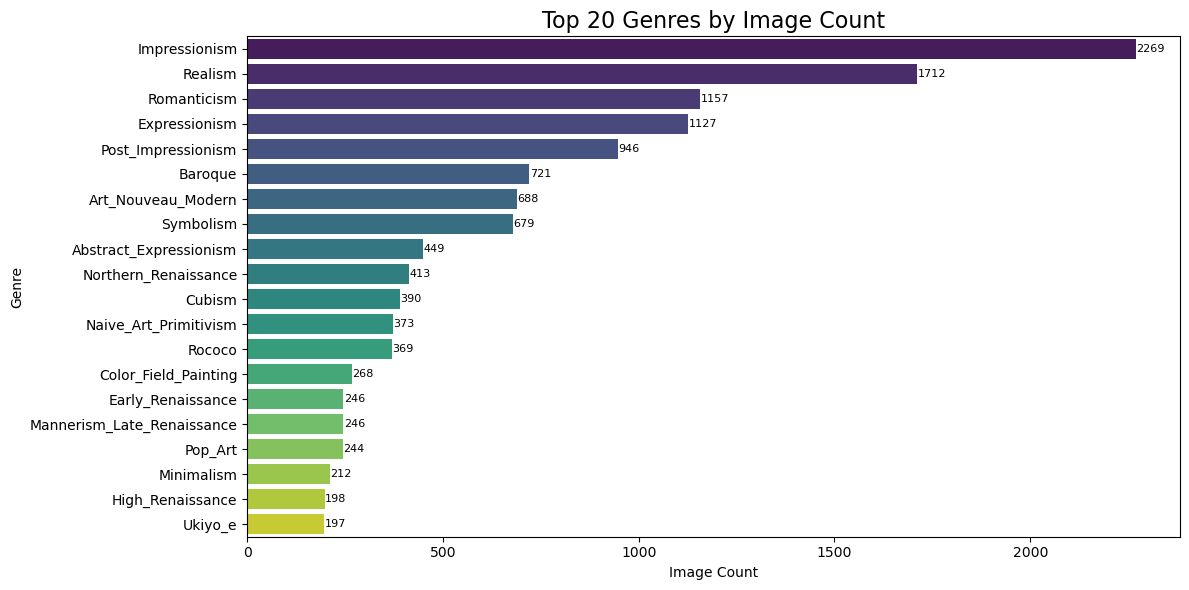

In [252]:
plt.figure(figsize = (12, 6))
sns.barplot(data = top_genres_df.sort_values("Count", ascending = False), x = "Count", y = "Genre", palette = "viridis")
plt.title("Top 20 Genres by Image Count", fontsize = 16)
plt.xlabel("Image Count")
plt.ylabel("Genre")
for index, row in top_genres_df.sort_values("Count", ascending = False).iterrows():
    plt.text(row["Count"] + 1, index, row["Count"], color = 'black', va = "center", fontsize = 8)
plt.tight_layout()
plt.show()

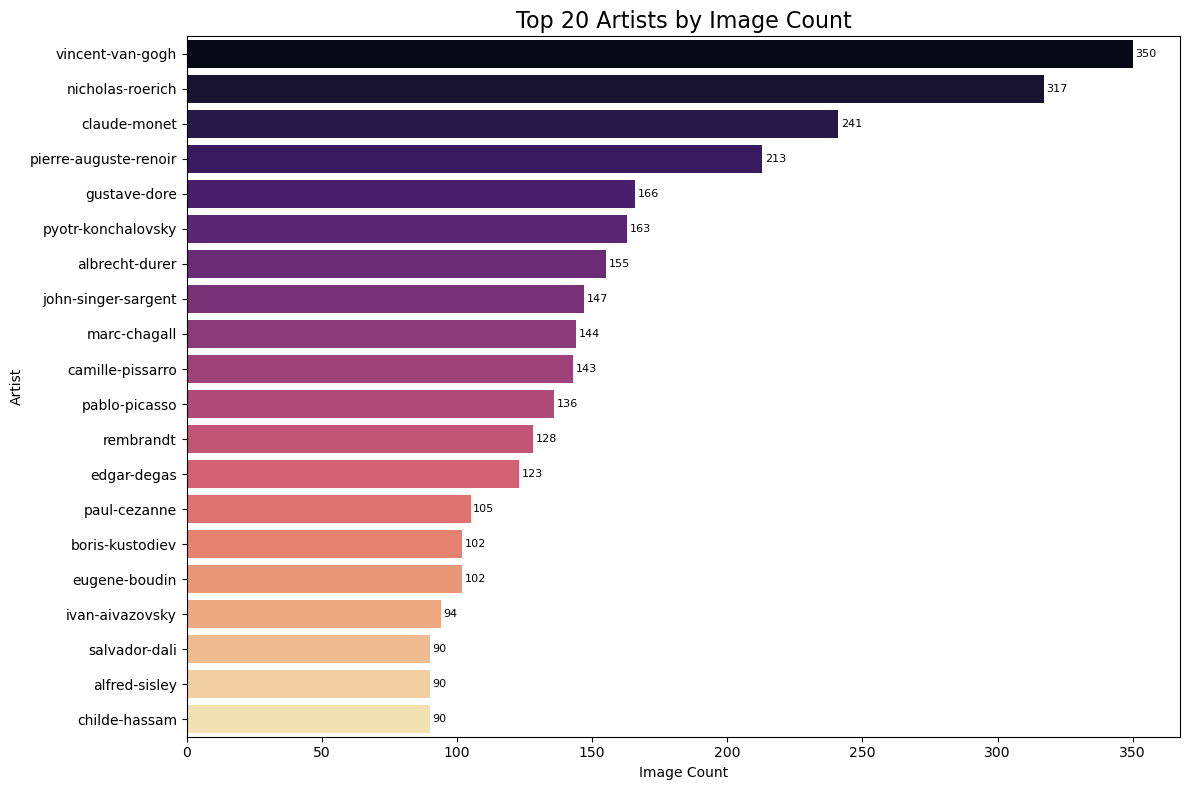

In [253]:
plt.figure(figsize = (12, 8))
sns.barplot(data = top_artists_df.sort_values("Count", ascending = False), x = "Count", y = "Artist", palette = "magma")
plt.title("Top 20 Artists by Image Count", fontsize = 16)
plt.xlabel("Image Count")
plt.ylabel("Artist")
for index, row in top_artists_df.sort_values("Count", ascending = False).iterrows():
    plt.text(row["Count"] + 1, index, row["Count"], color = 'black', va = "center", fontsize = 8)
plt.tight_layout()
plt.show()

In [131]:
def show_images_by_genre(top_genres_df, root_dir, n_per_genre = 2):
    plt.figure(figsize = (18, len(top_genres_df) * 2.5))
    for idx, row in top_genres_df.iterrows():
        genre = row['Genre']
        genre_path = os.path.join(root_dir, genre)
        img_files = [f for f in os.listdir(genre_path) if f.endswith(('.jpg', '.png'))]
        samples = random.sample(img_files, min(n_per_genre, len(img_files)))
        for j, fname in enumerate(samples):
            img_path = os.path.join(genre_path, fname)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size = IMG_SIZE)
            plt.subplot(len(top_genres_df), n_per_genre, idx * n_per_genre + j + 1)
            plt.imshow(img)
            plt.title(f"{genre}", fontsize = 8)
            plt.axis('off')
    plt.suptitle("Samples from Most Common Genres", fontsize = 16)
    plt.tight_layout()
    plt.subplots_adjust(top = 0.95)
    plt.show()

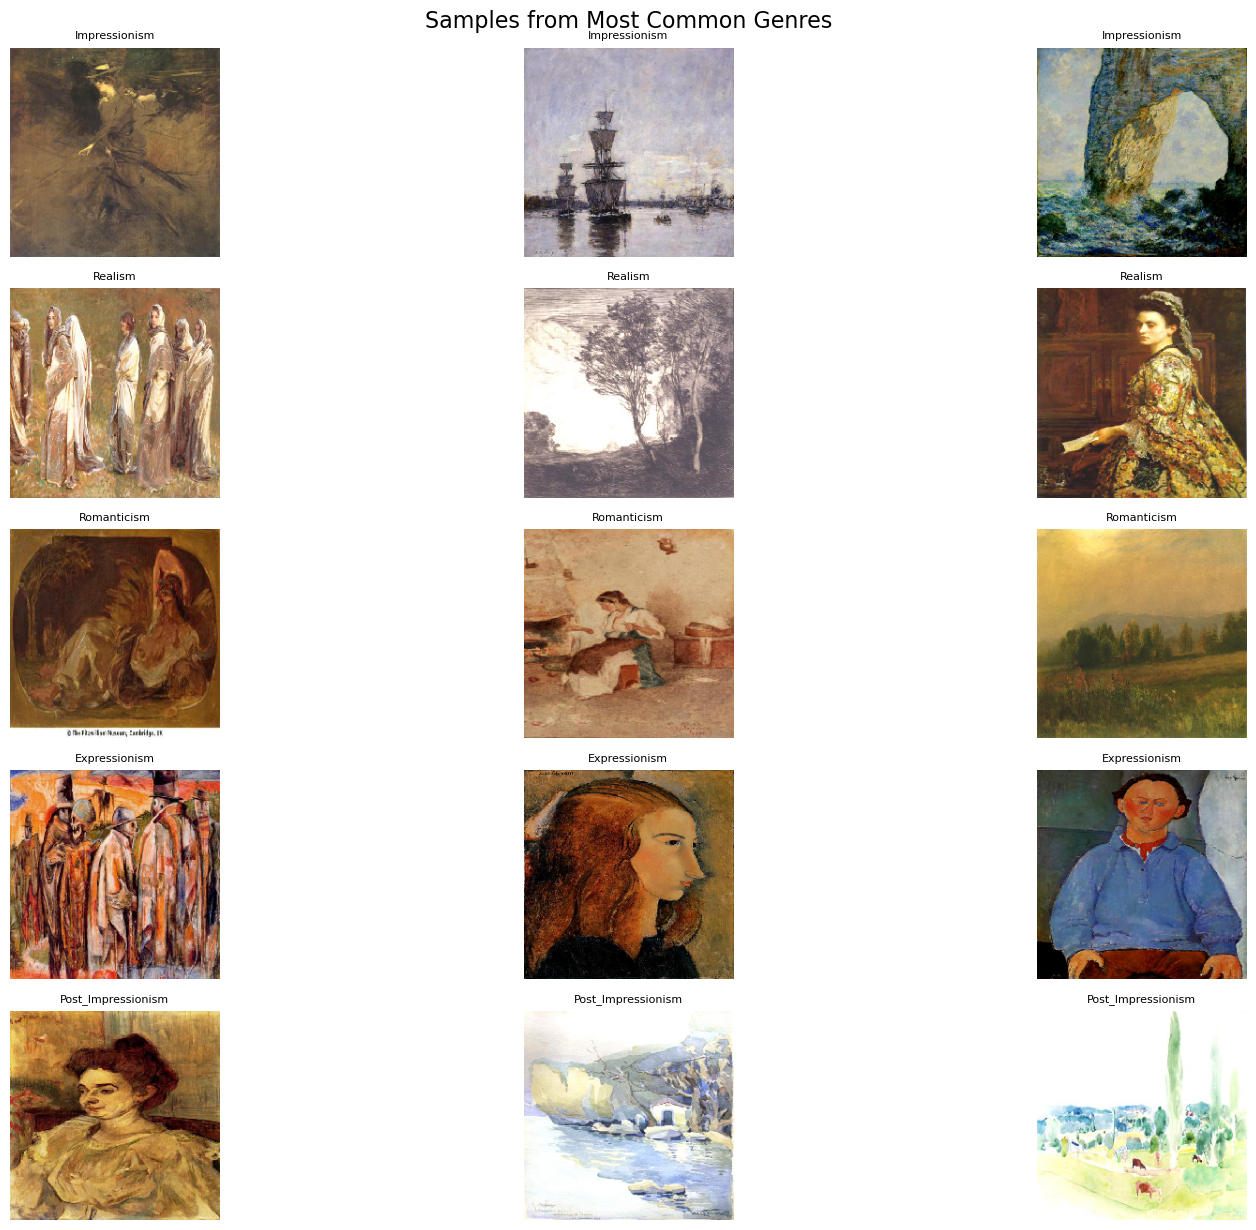

In [132]:
show_images_by_genre(top_genres_df.head(5), train_dir, n_per_genre=3)


In [250]:
def show_images_by_artist(top_artists_df, train_dir, genre_classes, n_per_artist = 3):
    plt.figure(figsize = (18, len(top_artists_df) * 2.5))
    shown = 0
    for idx, row in top_artists_df.iterrows():
        artist = row['Artist']
        found = False
        for genre in genre_classes:
            genre_path = os.path.join(train_dir, genre)
            for fname in os.listdir(genre_path):
                if fname.startswith(artist + "_"):
                    if not found:
                        samples = [f for f in os.listdir(genre_path) if f.startswith(artist + "_")][:n_per_artist]
                        for j, sample in enumerate(samples):
                            img_path = os.path.join(genre_path, sample)
                            img = tf.keras.preprocessing.image.load_img(img_path, target_size = IMG_SIZE)
                            plt.subplot(len(top_artists_df), n_per_artist, shown * n_per_artist + j + 1)
                            plt.imshow(img)
                            plt.title(f"{artist}", fontsize=8)
                            plt.axis('off')
                        shown += 1
                        found = True
                    break
            if found:
                break
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()


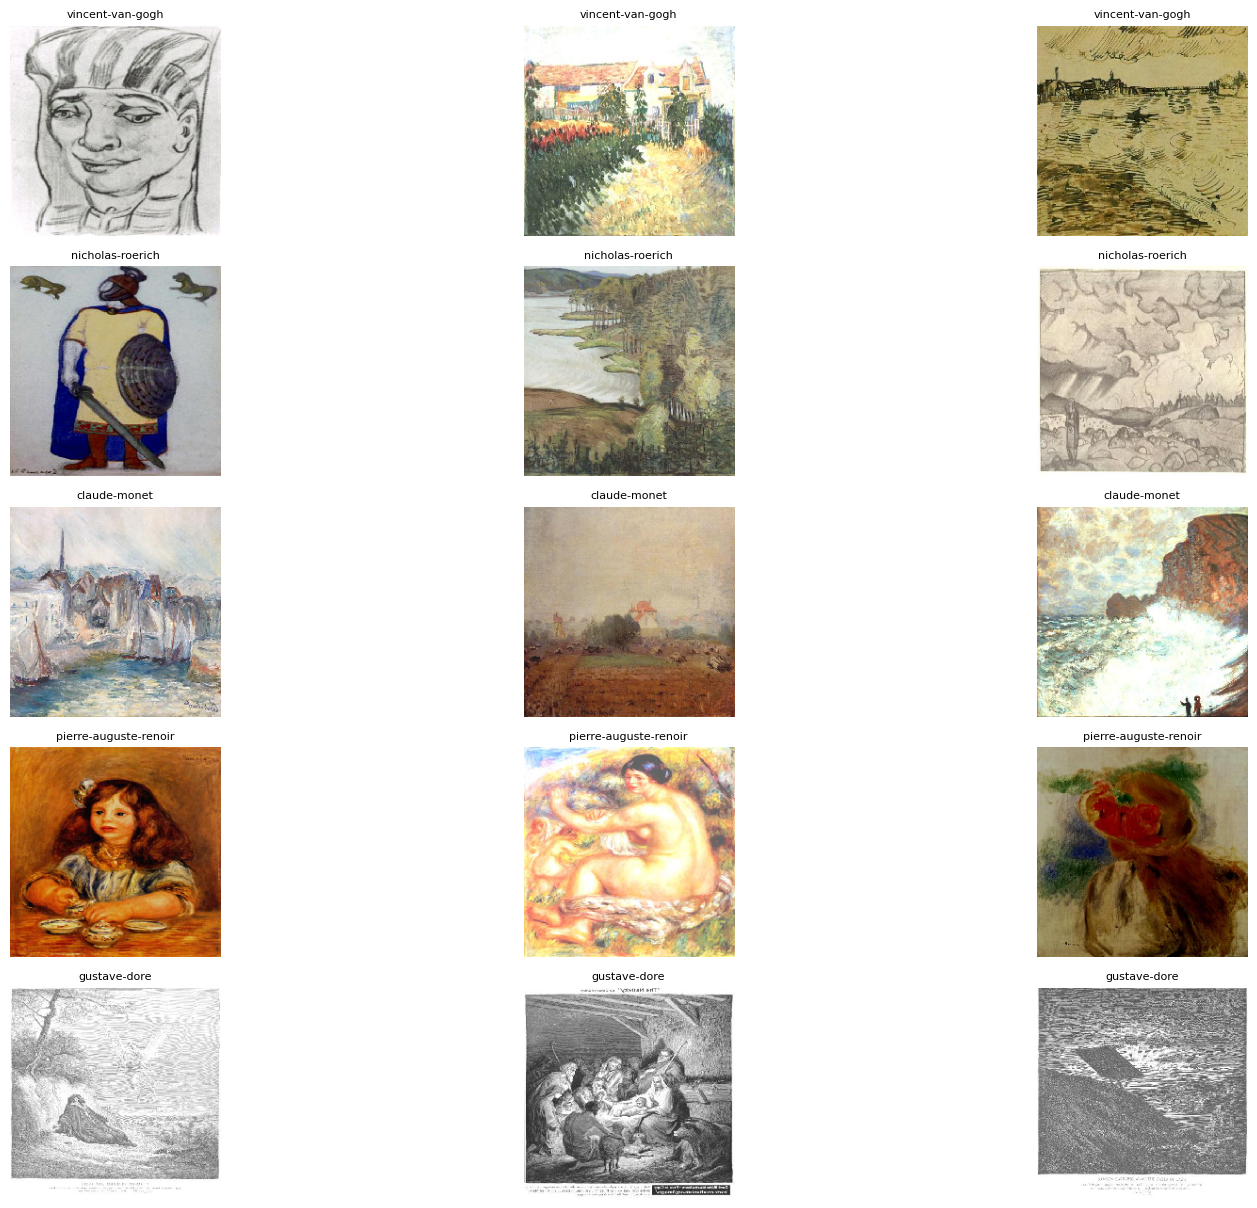

In [251]:
show_images_by_artist(top_artists_df.head(5), train_dir, train_genre_classes, n_per_artist = 3)

In [135]:
print(top_NUM_ARTISTS)
print(top_NUM_GENRES)

50
26


In [136]:
artist_classes = [artist for artist, count in artist_counts.items() if count >= 50]
NUM_ARTISTS = len(artist_classes)
NUM_GENRES = len(train_genre_classes)

In [137]:
print(NUM_ARTISTS)
print(NUM_GENRES)

47
27


In [138]:
print(f"Number of artists with >=50 samples: {len(artist_classes)}")


Number of artists with >=50 samples: 47


In [139]:
def imbalance_ratio(counter_obj): 
    counts = np.array(list(counter_obj.values())) #counts to numpy
    return counts.max() / (counts.min() + 1e-8) 

In [140]:
#calcuating class imbalance ratios for genre & artist labels
genre_ratio = imbalance_ratio(genre_counts)
artist_ratio = imbalance_ratio(artist_counts)
print(f"Genre imbalance ratio: {genre_ratio:.2f}")
print(f"Artist imbalance ratio: {artist_ratio:.2f}")

Genre imbalance ratio: 151.27
Artist imbalance ratio: 175.00


In [141]:
#class weights inversely prop. to freq. of each artist 
genre_class_weight = {
    i: 1.0 / count
    for i, genre in enumerate(train_genre_classes)
    if (count := genre_counts.get(genre, 0)) > 0
}
artist_class_weight = {
    i: 1.0 / count
    for i, artist in enumerate(artist_classes)
    if (count := artist_counts.get(artist, 0)) > 0
}


In [195]:
def custom_generator(file_paths, batch_size, genre_classes, artist_classes, 
                     genre_class_weight, artist_class_weight, shuffle = True, 
                     use_mixup = False, alpha = 0.2):
    while True: #inf. loop to keep creating batches
        if shuffle:
            np.random.shuffle(file_paths)
        for i in range(0, len(file_paths), batch_size):
            batch_paths = file_paths[i:i + batch_size]
            x_batch = []
            genre_labels = []
            artist_labels = []
            genre_weights = []
            artist_weights = []
            for path in batch_paths: 
                genre = os.path.basename(os.path.dirname(path)) #genre from folder name 
                artist = extract_artist_from_filename(os.path.basename(path)) #artist from filename 
                try:
                    artist_idx = artist_classes.index(artist)
                except ValueError:
                    continue #skipping if artist not in class list 
                img = tf.keras.preprocessing.image.load_img(path, target_size = (224, 224)) #loading & prepocessing images
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
                genre_idx = genre_classes.index(genre) #converting labels to one-hot code
                artist_idx = artist_classes.index(artist)
                genre_one_hot = tf.keras.utils.to_categorical(genre_idx, num_classes = len(genre_classes))
                artist_one_hot = tf.keras.utils.to_categorical(artist_idx, num_classes = len(artist_classes))
                x_batch.append(img_array) #append into batch list 
                genre_labels.append(genre_one_hot)
                artist_labels.append(artist_one_hot)
                genre_weights.append(genre_class_weight[genre_idx])
                artist_weights.append(artist_class_weight[artist_idx])
            if len(x_batch) == 0:
                continue #skipping empty batches 
            x_batch = np.array(x_batch) #converting lists to arrays 
            genre_labels = np.array(genre_labels)
            artist_labels = np.array(artist_labels)
            genre_weights = np.array(genre_weights)
            artist_weights = np.array(artist_weights)
            if use_mixup and len(x_batch) >= 2: #applying mixup augmentation (if only enabled)
                lam = np.random.beta(alpha, alpha)
                indices = np.random.permutation(len(x_batch))
                x1, x2 = x_batch, x_batch[indices]
                g1, g2 = genre_labels, genre_labels[indices]
                a1, a2 = artist_labels, artist_labels[indices]
                gw1, gw2 = genre_weights, genre_weights[indices]
                aw1, aw2 = artist_weights, artist_weights[indices]
                x_batch = lam * x1 + (1 - lam) * x2
                genre_labels = lam * g1 + (1 - lam) * g2
                artist_labels = lam * a1 + (1 - lam) * a2
                genre_weights = lam * gw1 + (1 - lam) * gw2
                artist_weights = lam * aw1 + (1 - lam) * aw2
            yield x_batch, { #yield batch as tuple (ie: inputs, labels, sample weights)
                'genre': genre_labels,
                'artist': artist_labels
            }, {
                'genre': genre_weights,
                'artist': artist_weights
            }

In [196]:
def get_image_paths(directory, genre_classes):
    image_paths = []
    for genre in genre_classes:
        genre_path = os.path.join(directory, genre)
        for fname in os.listdir(genre_path):
            if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                image_paths.append(os.path.join(genre_path, fname))
    return image_paths

In [197]:
#getting all file paths for train, val, & test sets 
train_file_paths = get_image_paths(train_dir, train_genre_classes)
valid_file_paths = get_image_paths(valid_dir, valid_genre_classes)
test_file_paths = get_image_paths(test_dir, test_genre_classes)

In [198]:
##mapping img paths to corresponding genre for anlaysis 
image_to_genre = {}
for img_path in train_file_paths:
    genre = os.path.basename(os.path.dirname(img_path))
    image_to_genre[img_path] = genre

## Plots

In [199]:
##display random images w. genre and artist metadata
def show_random_images(image_paths, genre_classes, n = 3):
    plt.figure(figsize = (15, 10))
    for i in range(n):
        img_path = random.choice(image_paths)
        genre = os.path.basename(os.path.dirname(img_path))
        filename = os.path.basename(img_path)
        artist_name = filename.split("_")[0]  
        img = tf.keras.preprocessing.image.load_img(img_path, target_size = IMG_SIZE)
        plt.subplot(3, 4, i+1)
        plt.imshow(img)
        plt.title(f"Genre: {genre}\nArtist: {artist_name}", fontsize = 9)
        plt.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

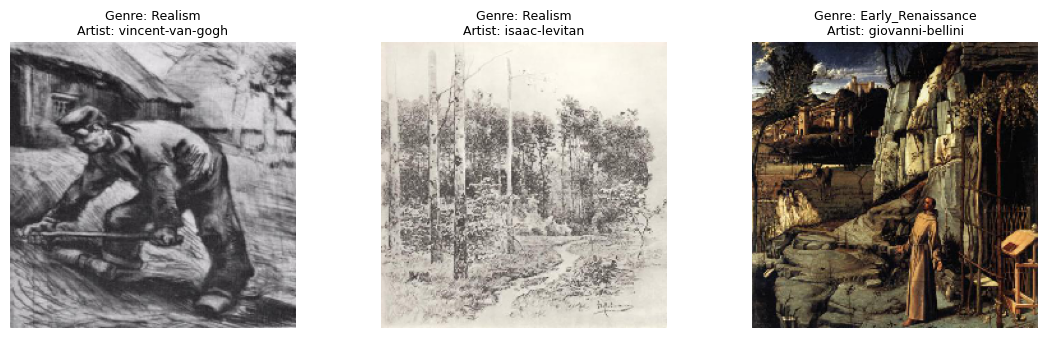

In [200]:
show_random_images(train_file_paths, train_genre_classes)

In [201]:
##running yolo model on 10 samples to detect objects
model_yolo = YOLO("yolov8n.pt")

In [202]:
for img_path in train_file_paths[:10]: 
    results = model_yolo(img_path)
    results[0].show()


image 1/1 /Users/hadleygriffin/MSDS 458/wiki-art-2/train/Abstract_Expressionism/arthur-pinajian_untitled-landscape-bellport-no-1042-1991_jpg.rf.931ec4872f3f6720d6a39e6d95b56b88.jpg: 640x640 1 bird, 90.6ms
Speed: 5.7ms preprocess, 90.6ms inference, 9.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/hadleygriffin/MSDS 458/wiki-art-2/train/Abstract_Expressionism/cy-twombly_quattro-stagioni-estate-1995_jpg.rf.357df036dab7b0f54b8172ec7dd1f466.jpg: 640x640 (no detections), 83.8ms
Speed: 3.3ms preprocess, 83.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/hadleygriffin/MSDS 458/wiki-art-2/train/Abstract_Expressionism/gerhard-richter_abstract-painting-610-1_jpg.rf.b48e55274d22bbaf23648f82e45608c3.jpg: 640x640 (no detections), 83.8ms
Speed: 2.2ms preprocess, 83.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/hadleygriffin/MSDS 458/wiki-art-2/train/Abstract_Expressionism/richard-pousette-dart_gold

In [149]:
#VGG16 model w/out classification head 
model_feature_extractor = VGG19(weights = 'imagenet', include_top = False)

In [150]:
#flatten CNN features for image 
def extract_features_vgg(img_path):
    img = image.load_img(img_path, target_size = (224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x = preprocess_input(x)
    features = model_feature_extractor.predict(x)
    return features.flatten()

In [151]:
##extracting features for first 50 training images
all_features = []
for img_path in train_file_paths[:50]:
    features = extract_features_vgg(img_path)
    all_features.append(features)
all_features = np.array(all_features)
print(all_features.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

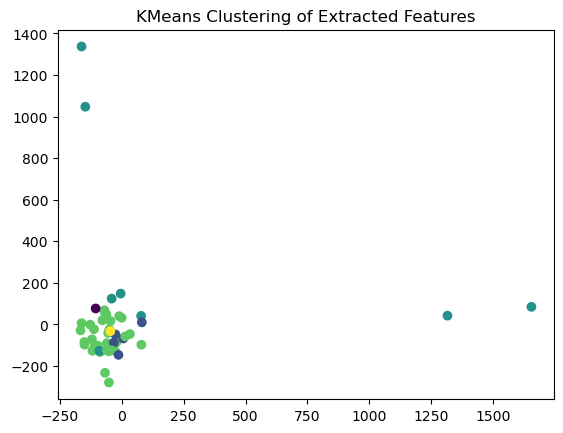

In [152]:
##kmeans clustering to extracted features 
kmeans = KMeans(n_clusters = 5, random_state = 42)
clusters = kmeans.fit_predict(all_features)
plt.scatter(features_2d[:, 0], features_2d[:, 1], c = clusters)
plt.title('KMeans Clustering of Extracted Features')
plt.show()

In [153]:
##cosine similarity b/w all feature vectors 
similarity_matrix = cosine_similarity(all_features)

In [154]:
nearest_neighbors = []
for i in range(len(all_features)):
    similarity_matrix[i, i] = -np.inf  #ignore similarity to self 
    nn_idx = np.argmax(similarity_matrix[i])
    nearest_neighbors.append(nn_idx)

In [155]:
def show_image_pair(idx1, idx2):
    fig, axes = plt.subplots(1, 2, figsize = (10, 5))
    img1 = image.load_img(train_file_paths[idx1], target_size = (224, 224))
    img2 = image.load_img(train_file_paths[idx2], target_size = (224, 224))
    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[0].set_title(f"Image 1\nGenre: {image_to_genre[train_file_paths[idx1]]}")
    axes[1].imshow(img2)
    axes[1].axis('off')
    axes[1].set_title(f"Nearest Neighbor\nGenre: {image_to_genre[train_file_paths[idx2]]}")
    plt.show()

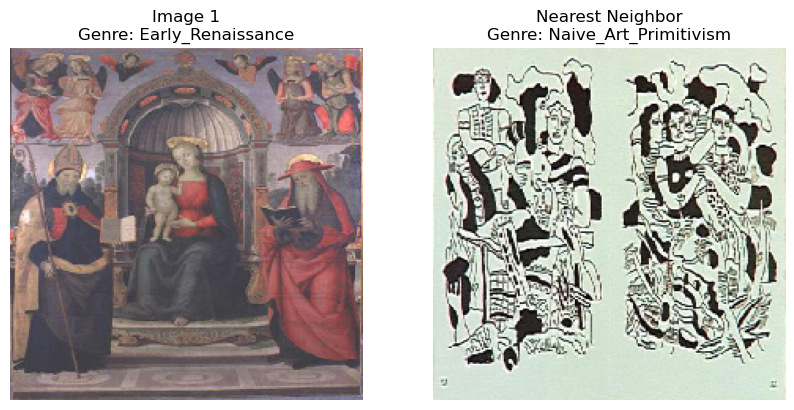

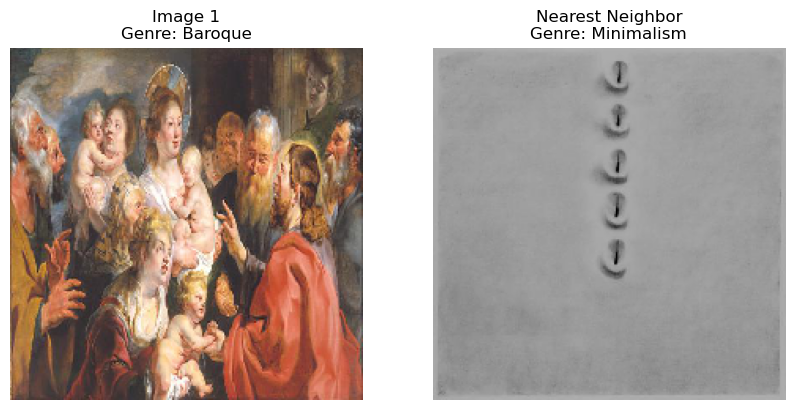

In [270]:
for i in range(2):
    show_image_pair(i, nearest_neighbors[i])

## Model Generator

In [203]:
train_generator = custom_generator(
    file_paths = train_file_paths,
    batch_size = BATCH_SIZE,
    genre_classes = train_genre_classes,
    artist_classes = artist_classes,
    genre_class_weight = genre_class_weight,
    artist_class_weight = artist_class_weight,
    shuffle = True,
    use_mixup = True,  #to enable mixup 
    alpha = 0.2           #hyperparamter for mixup 
)

In [204]:
val_generator = custom_generator(
    file_paths = valid_file_paths,
    batch_size = BATCH_SIZE,
    genre_classes = train_genre_classes,
    artist_classes = artist_classes,
    genre_class_weight = genre_class_weight,
    artist_class_weight = artist_class_weight,
    shuffle = False, #no shuffle 
    use_mixup = False     #no mixup 
)

In [205]:
test_generator = custom_generator(
    file_paths = test_file_paths,
    batch_size = BATCH_SIZE,
    genre_classes = test_genre_classes,
    artist_classes = test_artist_classes,
    genre_class_weight = genre_class_weight,
    artist_class_weight = artist_class_weight,
    shuffle = False, #no shuffle 
    use_mixup = False  #no mixup 
)

In [206]:
def count_images(directory):
    total = 0
    for root, dirs, files in os.walk(directory):
        total += len([f for f in files if f.endswith(('.jpg', '.png', '.jpeg'))])
    return total
train_samples = count_images(train_dir)
valid_samples = count_images(valid_dir)

## EfficientNetB3 Model Build:

In [207]:
inputs = Input(shape = (224, 224, 3))
base_model = EfficientNetB3(include_top = False, input_tensor = inputs, weights = 'imagenet') #imagenet
base_model.trainable = False

In [208]:
x = GlobalAveragePooling2D()(base_model.output) #reducing feature maps to single vector
x = Dropout(0.2)(x)m #regularization 

In [209]:
##genre classification head 
genre_dense = layers.Dense(256, activation = 'relu')(x)
genre_dense = layers.BatchNormalization()(genre_dense)
genre_dense = layers.Dropout(0.3)(genre_dense)
genre_output = layers.Dense(NUM_GENRES, activation = 'softmax', name = 'genre')(genre_dense)

In [210]:
##artist classification head 
artist_dense = layers.Dense(512, activation = 'relu')(x)
artist_dense = layers.BatchNormalization()(artist_dense)
artist_dense = layers.Dropout(0.4)(artist_dense)
artist_output = layers.Dense(NUM_ARTISTS, activation = 'softmax', name = 'artist')(artist_dense)

In [211]:
#categorical focal loss function 
def categorical_focal_loss(gamma = 2.0, alpha = 0.25):
    def focal_loss(y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_sum(loss, axis = 1)
    return focal_loss

In [212]:
#categorical focal loss function 
loss_fn = categorical_focal_loss(alpha = 0.25, gamma = 2.0)

In [213]:
#learning rate scheudler 
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 1e-4,  #inital learning rate 
    decay_steps = 10000,           #decay 
    decay_rate = 0.9,            
    staircase = True  #decay in discrept intervals 
)

In [214]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4) #compile model w. optimizer 

In [215]:
##final model with two outputs 
model = Model(inputs = inputs, outputs = {'genre': genre_output, 'artist': artist_output})
model.compile(
    optimizer = optimizer,
    loss = {'genre': 'categorical_crossentropy', 'artist': 'categorical_crossentropy'},
    loss_weights = {'genre': 0.7, 'artist': 0.3},
    metrics = {'genre': tf.keras.metrics.TopKCategoricalAccuracy(k = 5),
         'artist': tf.keras.metrics.TopKCategoricalAccuracy(k = 5)}
)


In [216]:
##training callbacks 
callbacks = [
    ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, verbose = 1),
    EarlyStopping(monitor='val_loss', patience = 6, restore_best_weights = True),
    ModelCheckpoint('enhanced_model.keras', save_best_only = True)
]

In [217]:
x_sample, y_sample, sample_weights = next(train_generator) #prep data generators 

In [218]:
## steps per epoch 
steps_per_epoch = len(train_file_paths) // BATCH_SIZE
validation_steps = len(valid_file_paths) // BATCH_SIZE

In [219]:
## train efficentnet model
history = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_generator,
    validation_steps = validation_steps,
    epochs = 10,
    callbacks = callbacks,
    verbose = 1
)

Epoch 1/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 147s 342ms/step - artist_loss: 0.0136 - artist_top_k_categorical_accuracy: 0.1722 - genre_loss: 0.0035 - genre_top_k_categorical_accuracy: 0.2616 - loss: 0.0171 - val_artist_loss: 0.0086 - val_artist_top_k_categorical_accuracy: 0.4976 - val_genre_loss: 0.0032 - val_genre_top_k_categorical_accuracy: 0.5457 - val_loss: 0.0112 - learning_rate: 1.0000e-04
Epoch 2/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 155s 373ms/step - artist_loss: 0.0097 - artist_top_k_categorical_accuracy: 0.4422 - genre_loss: 0.0026 - genre_top_k_categorical_accuracy: 0.4889 - loss: 0.0122 - val_artist_loss: 0.0076 - val_artist_top_k_categorical_accuracy: 0.6019 - val_genre_loss: 0.0028 - val_genre_top_k_categorical_accuracy: 0.6529 - val_loss: 0.0098 - learning_rate: 1.0000e-04
Epoch 3/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 154s 370ms/step - artist_loss: 0.0083 - artist_top_k_categorical_accuracy: 0.5606 - genre_loss: 0.0023 - genre_top_k_categorical_accuracy: 0.6009 - loss: 0.0106 - val_artis

In [271]:
model.save("efficentnetb3_model.keras")

In [226]:
##unfreeze frozen layers 
base_model.trainable = True
for layer in base_model.layers:
    layer.trainable = True

In [227]:
##training compiling with lower learning rate 
model.compile(
    optimizer = Adam(learning_rate = 1e-5),
    loss = {'genre': 'categorical_crossentropy', 'artist': 'categorical_crossentropy'},
    loss_weights = {'genre': 0.7, 'artist': 0.3},
    metrics = {
        'genre': [tf.keras.metrics.TopKCategoricalAccuracy(k=5)],
        'artist': [tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
    }
)

In [228]:
#finetuning EfficentNetB3 model
history_finetune = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_generator,
    validation_steps = validation_steps,
    epochs = 10,
    callbacks = callbacks 
)

Epoch 1/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 759s 2s/step - artist_loss: 0.0089 - artist_top_k_categorical_accuracy: 0.5501 - genre_loss: 0.0022 - genre_top_k_categorical_accuracy: 0.6845 - loss: 0.0110 - val_artist_loss: 0.0088 - val_artist_top_k_categorical_accuracy: 0.5419 - val_genre_loss: 0.0030 - val_genre_top_k_categorical_accuracy: 0.7512 - val_loss: 0.0110 - learning_rate: 1.0000e-05
Epoch 2/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 771s 2s/step - artist_loss: 0.0083 - artist_top_k_categorical_accuracy: 0.6102 - genre_loss: 0.0021 - genre_top_k_categorical_accuracy: 0.7120 - loss: 0.0104 - val_artist_loss: 0.0084 - val_artist_top_k_categorical_accuracy: 0.5898 - val_genre_loss: 0.0029 - val_genre_top_k_categorical_accuracy: 0.7597 - val_loss: 0.0106 - learning_rate: 1.0000e-05
Epoch 3/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 1302s 3s/step - artist_loss: 0.0075 - artist_top_k_categorical_accuracy: 0.6834 - genre_loss: 0.0019 - genre_top_k_categorical_accuracy: 0.7585 - loss: 0.0093 - val_artist_loss: 

In [229]:
##GradCamFunction
def get_grad_cam(model, img_array, class_index, layer_name = 'top_conv', target_output = 'genre'):
    grad_model = Model(
        inputs = model.input,
        outputs = [model.get_layer(layer_name).output, model.output[target_output]]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-10)
    return heatmap.numpy()

In [230]:
def display_grad_cam(image_path, heatmap, alpha = 0.4):
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMG_SIZE)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cm.jet(heatmap)[..., :3]  
    superimposed_img = heatmap_color * 255 * alpha + img_rgb
    plt.figure(figsize = (8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(np.uint8(superimposed_img))
    plt.title("Grad-CAM")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


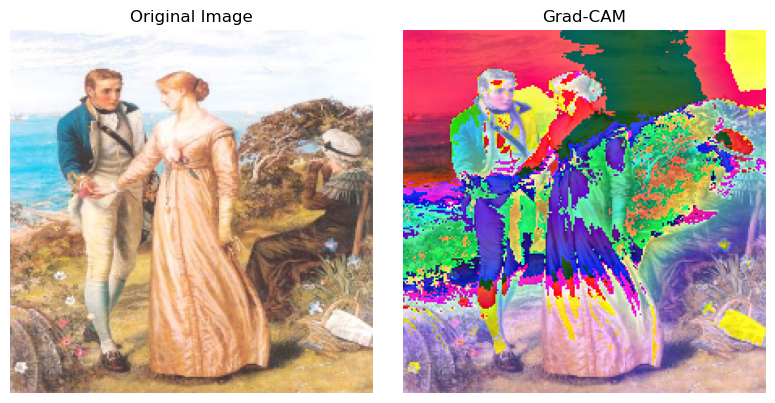

In [232]:
image_path = random.choice(train_file_paths)
img = tf.keras.preprocessing.image.load_img(image_path, target_size = IMG_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis = 0)

# Predict and get class index
preds = model.predict(img_array)
genre_pred = np.argmax(preds['genre'])

# Grad-CAM
heatmap = get_grad_cam(model, img_array, genre_pred, layer_name='top_conv', target_output='genre')
display_grad_cam(image_path, heatmap)

In [242]:
##Model prediction images 
def display_predictions(model, val_generator, genre_classes, artist_classes, num_to_show = 5):
    x_batch, y_batch, _ = next(val_generator)
    preds = model.predict(x_batch)
    for i in range(num_to_show):
        image = x_batch[i]
        image_to_show = image / 255.0
        image_to_show = np.clip(image_to_show, 0, 1)
        predicted_genre = genre_classes[np.argmax(preds['genre'][i])]
        true_genre = genre_classes[np.argmax(y_batch['genre'][i])]
        predicted_artist = artist_classes[np.argmax(preds['artist'][i])]
        true_artist = artist_classes[np.argmax(y_batch['artist'][i])]
        plt.figure(figsize = (4, 4))
        plt.imshow(image_to_show)
        plt.axis('off')
        plt.title(
            f"Predicted: {predicted_genre}, {predicted_artist}\n"
            f"Actual: {true_genre}, {true_artist}",
            fontsize = 9
        )
        print(f"Image shape: {image_to_show.shape}, dtype: {image_to_show.dtype}")
        print(f"Min pixel value: {image_to_show.min()}, Max pixel value: {image_to_show.max()}")
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
Image shape: (224, 224, 3), dtype: float32
Min pixel value: 0.0, Max pixel value: 1.0


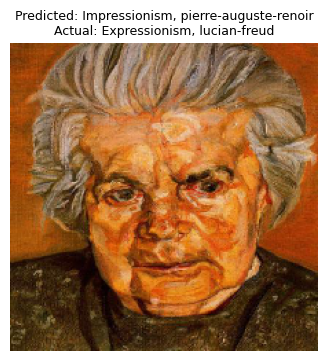

Image shape: (224, 224, 3), dtype: float32
Min pixel value: 0.0, Max pixel value: 1.0


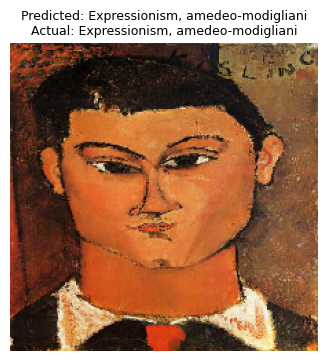

Image shape: (224, 224, 3), dtype: float32
Min pixel value: 0.0, Max pixel value: 1.0


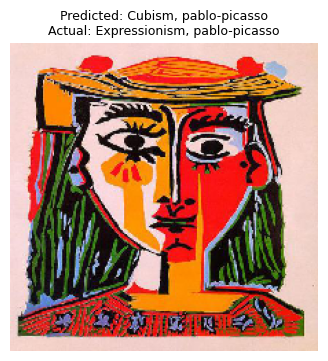

In [383]:
display_predictions(model, val_generator, train_genre_classes, artist_classes, num_to_show = 3)

## ResNet Model: 

In [254]:
inputs = Input(shape = (224, 224, 3))
base_model = ResNet50(include_top=False, input_tensor = inputs, weights = 'imagenet')
base_model.trainable = False

In [255]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)

In [256]:
genre_dense = layers.Dense(256, activation = 'relu')(x)
genre_dense = layers.BatchNormalization()(genre_dense)
genre_dense = layers.Dropout(0.3)(genre_dense)
genre_output = layers.Dense(NUM_GENRES, activation = 'softmax', name  ='genre')(genre_dense)

In [257]:
artist_dense = layers.Dense(512, activation = 'relu')(x)
artist_dense = layers.BatchNormalization()(artist_dense)
artist_dense = layers.Dropout(0.4)(artist_dense)
artist_output = layers.Dense(NUM_ARTISTS, activation = 'softmax', name = 'artist')(artist_dense)

In [258]:
resnet_model = Model(inputs = inputs, outputs = {'genre': genre_output, 'artist': artist_output})

In [259]:
resnet_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
    loss= {'genre': 'categorical_crossentropy', 'artist': 'categorical_crossentropy'},
    loss_weights = {'genre': 0.7, 'artist': 0.3},
    metrics = {'genre': tf.keras.metrics.TopKCategoricalAccuracy(k = 5),
             'artist': tf.keras.metrics.TopKCategoricalAccuracy(k = 5)}
)

In [260]:
history_resnet = resnet_model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_generator,
    validation_steps = validation_steps,
    epochs = 10,
    callbacks = callbacks,
    verbose = 1
)

Epoch 1/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 202s 479ms/step - artist_loss: 0.0128 - artist_top_k_categorical_accuracy: 0.2134 - genre_loss: 0.0035 - genre_top_k_categorical_accuracy: 0.2806 - loss: 0.0163 - val_artist_loss: 0.0079 - val_artist_top_k_categorical_accuracy: 0.5483 - val_genre_loss: 0.0030 - val_genre_top_k_categorical_accuracy: 0.6401 - val_loss: 0.0104 - learning_rate: 1.0000e-04
Epoch 2/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 228s 547ms/step - artist_loss: 0.0088 - artist_top_k_categorical_accuracy: 0.5080 - genre_loss: 0.0024 - genre_top_k_categorical_accuracy: 0.5265 - loss: 0.0112 - val_artist_loss: 0.0069 - val_artist_top_k_categorical_accuracy: 0.6492 - val_genre_loss: 0.0026 - val_genre_top_k_categorical_accuracy: 0.7494 - val_loss: 0.0090 - learning_rate: 1.0000e-04
Epoch 3/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 228s 546ms/step - artist_loss: 0.0075 - artist_top_k_categorical_accuracy: 0.6417 - genre_loss: 0.0021 - genre_top_k_categorical_accuracy: 0.6331 - loss: 0.0096 - val_artis

In [261]:
def display_predictions(model, val_generator, genre_classes, artist_classes, num_to_show=5):
    x_batch, y_batch, _ = next(val_generator)
    preds = model.predict(x_batch)
    for i in range(num_to_show):
        image = x_batch[i]
        image_to_show = image / 255.0
        image_to_show = np.clip(image_to_show, 0, 1)
        predicted_genre = genre_classes[np.argmax(preds['genre'][i])]
        true_genre = genre_classes[np.argmax(y_batch['genre'][i])]
        predicted_artist = artist_classes[np.argmax(preds['artist'][i])]
        true_artist = artist_classes[np.argmax(y_batch['artist'][i])]
        plt.figure(figsize = (4, 4))
        plt.imshow(image_to_show)
        plt.axis('off')
        plt.title(
            f"Predicted: {predicted_genre}, {predicted_artist}\n"
            f"Actual: {true_genre}, {true_artist}",
            fontsize = 9
        )
        print(f"Image shape: {image_to_show.shape}, dtype: {image_to_show.dtype}")
        print(f"Min pixel value: {image_to_show.min()}, Max pixel value: {image_to_show.max()}")
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Image shape: (224, 224, 3), dtype: float32
Min pixel value: 0.0, Max pixel value: 1.0


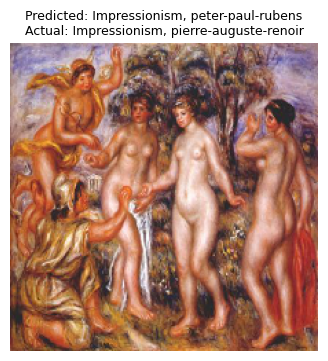

Image shape: (224, 224, 3), dtype: float32
Min pixel value: 0.0, Max pixel value: 0.929411768913269


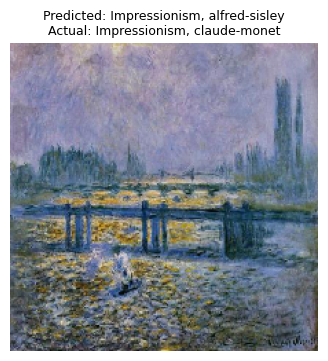

Image shape: (224, 224, 3), dtype: float32
Min pixel value: 0.0, Max pixel value: 1.0


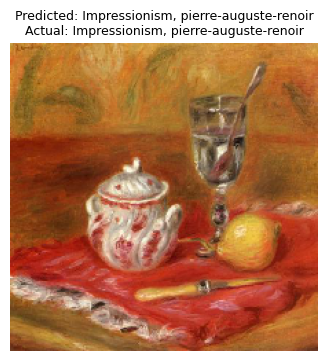

In [385]:
display_predictions(resnet_model, val_generator, train_genre_classes, artist_classes, num_to_show = 3)

In [263]:
def get_grad_cam(model, img_array, class_index, layer_name = 'top_conv', target_output = 'genre'):
    grad_model = Model(
        inputs =model.input,
        outputs = [model.get_layer(layer_name).output, model.output[target_output]]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis  =(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-10)
    return heatmap.numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


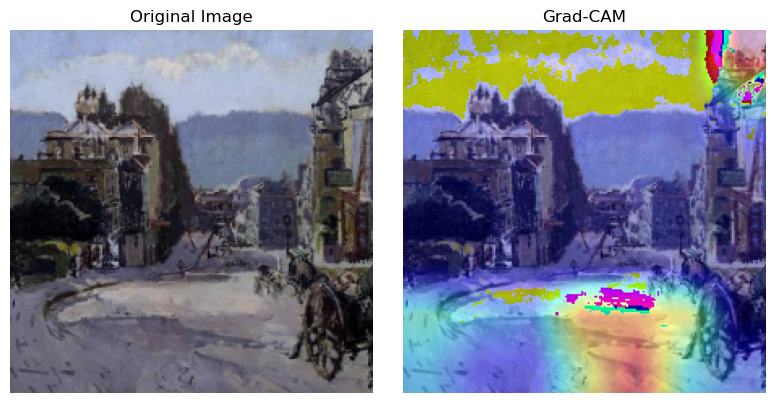

In [387]:
image_path = random.choice(train_file_paths)
img = tf.keras.preprocessing.image.load_img(image_path, target_size =IMG_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis = 0)
preds = resnet_model.predict(img_array)
genre_pred = np.argmax(preds['genre'])
heatmap = get_grad_cam(model, img_array, genre_pred, layer_name = 'top_conv', target_output = 'genre')
display_grad_cam(image_path, heatmap)

## EfficentNetB3 Analysis:

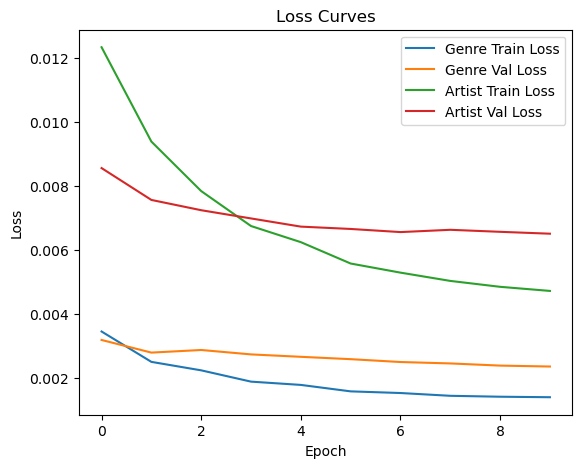

In [288]:
plt.figure(figsize = (14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['genre_loss'], label = 'Genre Train Loss')
plt.plot(history.history['val_genre_loss'], label = 'Genre Val Loss')
plt.plot(history.history['artist_loss'], label = 'Artist Train Loss')
plt.plot(history.history['val_artist_loss'], label = 'Artist Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


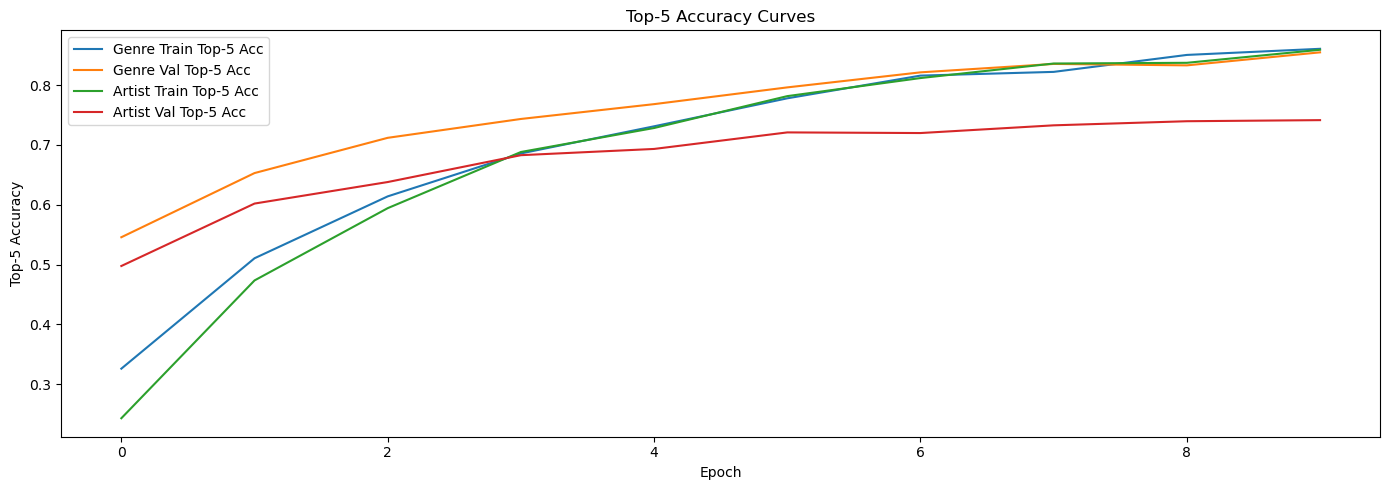

In [291]:
plt.figure(figsize = (14,5))
plt.plot(history.history['genre_top_k_categorical_accuracy'], label = 'Genre Train Top-5 Acc')
plt.plot(history.history['val_genre_top_k_categorical_accuracy'], label = 'Genre Val Top-5 Acc')
plt.plot(history.history['artist_top_k_categorical_accuracy'], label = 'Artist Train Top-5 Acc')
plt.plot(history.history['val_artist_top_k_categorical_accuracy'], label = 'Artist Val Top-5 Acc')
plt.title('Top-5 Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Top-5 Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [316]:
y_true_genre, y_true_artist = [], []
y_pred_genre, y_pred_artist = [], []

for i in range(validation_steps):
    x_batch, y_batch, _ = next(val_generator)
    preds = model.predict(x_batch)

    # True labels
    y_true_genre.append(np.argmax(y_batch['genre'], axis=1))
    y_true_artist.append(np.argmax(y_batch['artist'], axis=1))

    # Predicted labels
    y_pred_genre.append(np.argmax(preds['genre'], axis=1))
    y_pred_artist.append(np.argmax(preds['artist'], axis=1))

# Flatten into single arrays
y_true_genre = np.concatenate(y_true_genre)
y_pred_genre = np.concatenate(y_pred_genre)
y_true_artist = np.concatenate(y_true_artist)
y_pred_artist = np.concatenate(y_pred_artist)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/s

In [319]:
print(classification_report(y_true_genre, y_pred_genre, digits=2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         0
           3       0.31      0.28      0.30        32
           4       0.34      0.65      0.45        20
           5       0.00      0.00      0.00         3
           7       0.10      0.14      0.12         7
           9       0.56      0.21      0.31        42
          10       0.00      0.00      0.00         4
          12       0.54      0.61      0.57        89
          13       0.67      0.67      0.67         3
          15       0.07      0.50      0.12         2
          17       0.17      0.40      0.24        10
          18       0.00      0.00      0.00         3
          19       0.00      0.00      0.00         1
          20       0.33      0.23      0.27        48
          21       0.41      0.35      0.38        74
          23       0.64      0.39      0.49        23
          24       0.44    

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [320]:
print(classification_report(y_true_artist, y_pred_artist, digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         9
           1     0.1429    0.1000    0.1176        10
           2     0.2000    0.2000    0.2000         5
           3     0.1875    0.1875    0.1875        16
           4     0.0000    0.0000    0.0000         6
           5     0.4444    0.3077    0.3636        26
           6     0.1111    0.0833    0.0952        12
           7     0.1000    0.0833    0.0909        12
           8     0.1667    0.2000    0.1818         5
           9     0.0000    0.0000    0.0000         8
          10     0.2000    0.2500    0.2222         8
          11     0.2917    0.5833    0.3889        12
          12     0.3333    0.5000    0.4000         6
          13     0.2500    0.3333    0.2857         3
          14     0.0000    0.0000    0.0000         4
          15     0.0000    0.0000    0.0000         9
          16     0.2500    0.3333    0.2857         6
          17     0.1250    

In [321]:
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, 
                annot=False, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {title}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

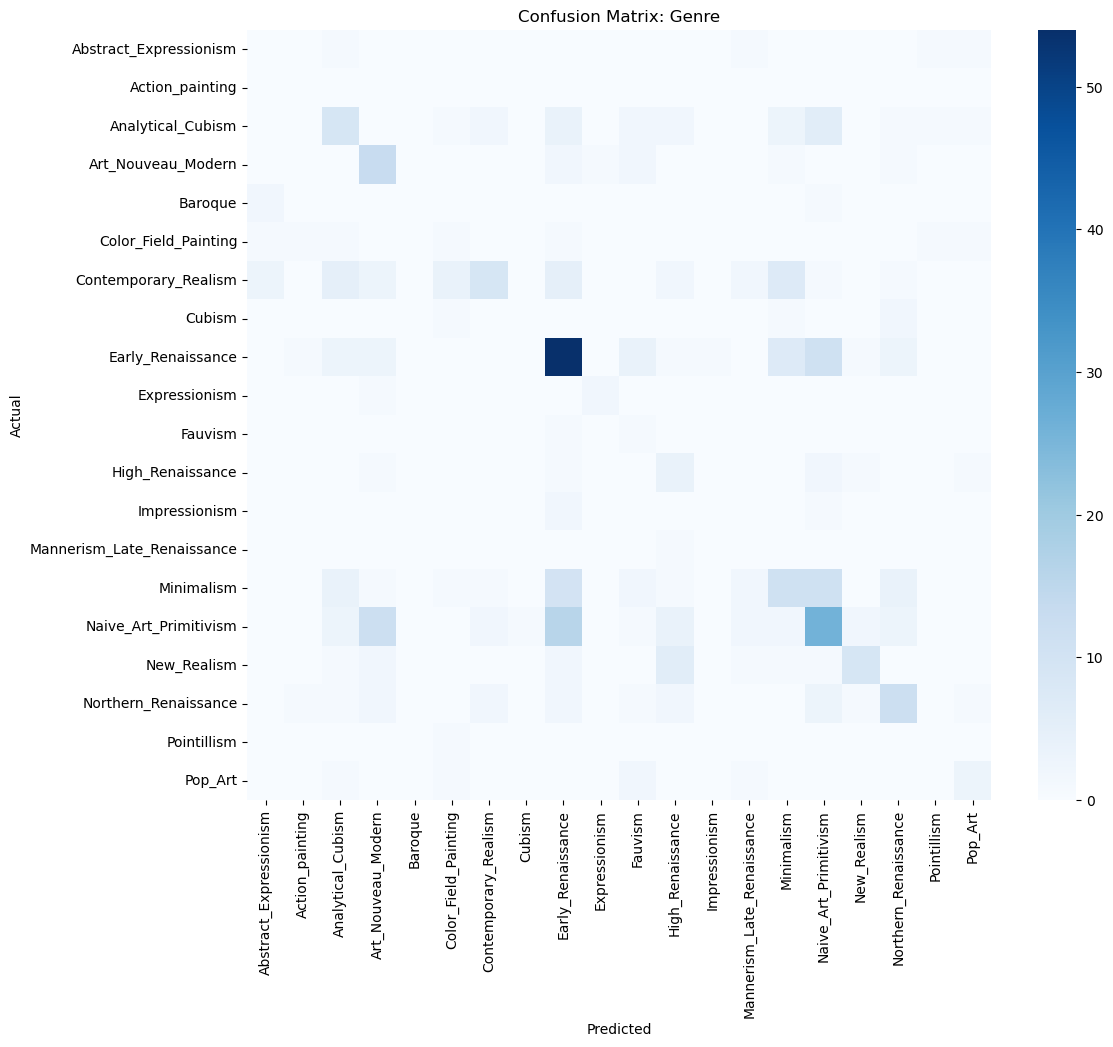

In [325]:
plot_confusion_matrix(y_true_genre, y_pred_genre, train_genre_classes[:20], "Genre")

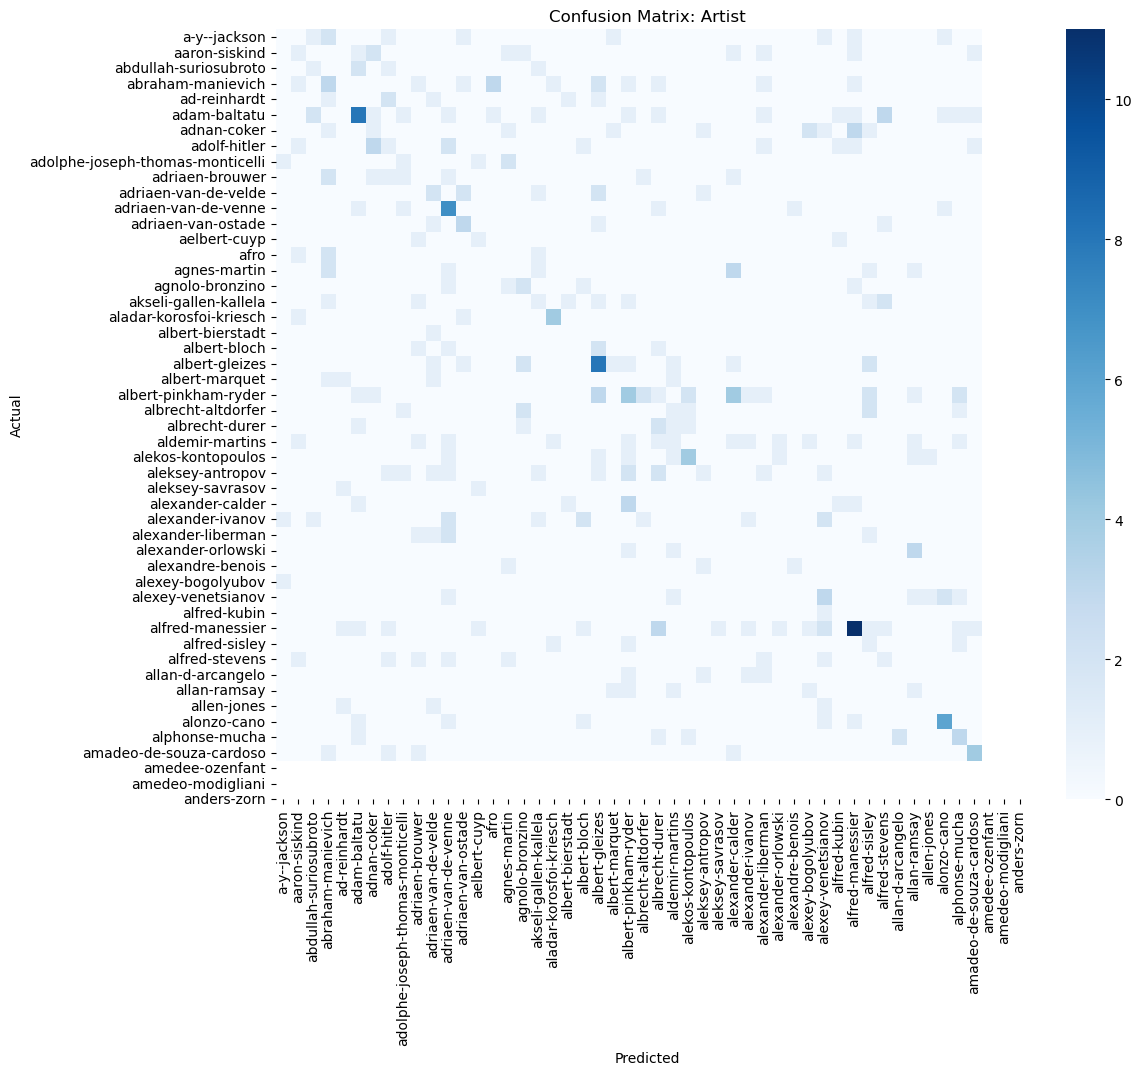

In [327]:
plot_confusion_matrix(y_true_artist, y_pred_artist, train_artist_classes[:50], "Artist")

In [341]:
genre_counter = Counter(predicted_genre_names)
artist_counter = Counter(predicted_artist_names)
top_genres_df = pd.DataFrame(genre_counter.most_common(10), columns=["Genre", "Count"])
top_artists_df = pd.DataFrame(artist_counter.most_common(10), columns=["Artist", "Count"])

In [346]:
print("Top 10 Predicted Genres:\n", top_genres_df)

Top 10 Predicted Genres:
                    Genre  Count
0          Impressionism    100
1                Realism     63
2                Baroque     38
3     Post_Impressionism     33
4     Art_Nouveau_Modern     29
5              Symbolism     27
6   Northern_Renaissance     23
7          Expressionism     16
8  Naive_Art_Primitivism     15
9            Romanticism     14


## ResNet Model Analysis: 

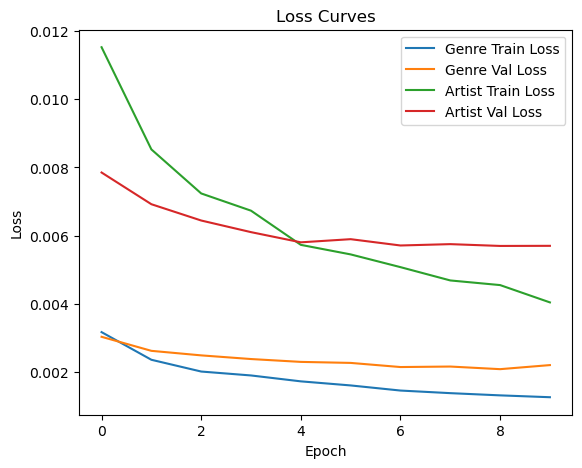

In [357]:
plt.figure(figsize = (14, 5))
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['genre_loss'], label = 'Genre Train Loss')
plt.plot(history_resnet.history['val_genre_loss'], label = 'Genre Val Loss')
plt.plot(history_resnet.history['artist_loss'], label = 'Artist Train Loss')
plt.plot(history_resnet.history['val_artist_loss'], label = 'Artist Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


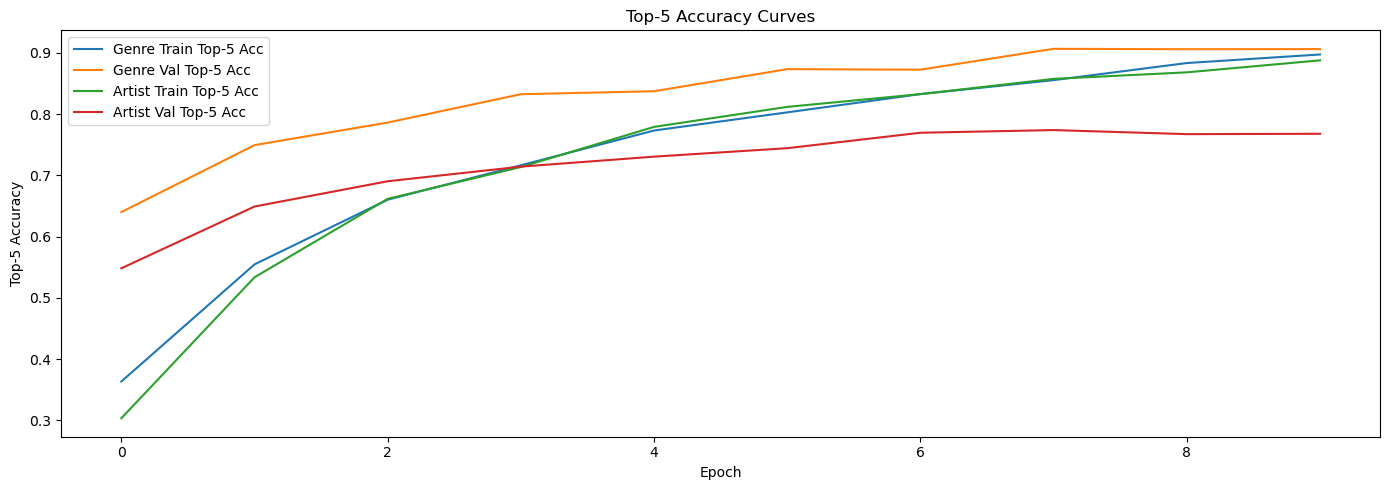

In [358]:
plt.figure(figsize = (14,5))
plt.plot(history_resnet.history['genre_top_k_categorical_accuracy'], label = 'Genre Train Top-5 Acc')
plt.plot(history_resnet.history['val_genre_top_k_categorical_accuracy'], label = 'Genre Val Top-5 Acc')
plt.plot(history_resnet.history['artist_top_k_categorical_accuracy'], label = 'Artist Train Top-5 Acc')
plt.plot(history_resnet.history['val_artist_top_k_categorical_accuracy'], label = 'Artist Val Top-5 Acc')
plt.title('Top-5 Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Top-5 Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [371]:
y_true_genre_RS, y_true_artist_RS = [], []
y_pred_genre_RS, y_pred_artist_RS = [], []

for i in range(validation_steps):
    x_batch, y_batch, _ = next(val_generator)
    preds = resnet_model.predict(x_batch)
    y_true_genre_RS.append(np.argmax(y_batch['genre'], axis=1))
    y_true_artist_RS.append(np.argmax(y_batch['artist'], axis=1))
    y_pred_genre_RS.append(np.argmax(preds['genre'], axis=1))
    y_pred_artist_RS.append(np.argmax(preds['artist'], axis=1))
y_true_genre_RS = np.concatenate(y_true_genre_RS)
y_pred_genre_RS = np.concatenate(y_pred_genre_RS)
y_true_artist_RS = np.concatenate(y_true_artist_RS)
y_pred_artist_RS = np.concatenate(y_pred_artist_RS)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [372]:
print(classification_report(y_true_genre_RS, y_pred_genre_RS, digits=2))

              precision    recall  f1-score   support

           0       0.40      0.50      0.44         4
           3       0.52      0.41      0.46        32
           4       0.53      0.50      0.51        20
           5       0.00      0.00      0.00         3
           7       0.50      0.43      0.46         7
           9       0.53      0.47      0.50        38
          10       0.00      0.00      0.00         0
          12       0.74      0.72      0.73       108
          13       0.40      0.67      0.50         3
          15       0.05      0.50      0.10         2
          17       0.35      0.60      0.44        10
          18       0.00      0.00      0.00         3
          19       0.00      0.00      0.00         1
          20       0.45      0.40      0.42        48
          21       0.54      0.43      0.48        74
          23       0.60      0.65      0.62        23
          24       0.72      0.64      0.68        28
          25       0.00    

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [373]:
print(classification_report(y_true_artist_RS, y_pred_artist_RS, digits=2))

              precision    recall  f1-score   support

           0       0.20      0.11      0.14         9
           1       0.43      0.33      0.38         9
           2       0.75      0.60      0.67         5
           3       0.58      0.47      0.52        15
           4       0.18      0.33      0.24         6
           5       0.64      0.69      0.67        26
           6       0.43      0.25      0.32        12
           7       0.58      0.58      0.58        12
           8       0.33      0.50      0.40         4
           9       0.22      0.25      0.24         8
          10       0.71      0.62      0.67         8
          11       0.73      0.67      0.70        12
          12       0.33      0.60      0.43         5
          13       0.50      0.33      0.40         3
          14       0.25      0.25      0.25         4
          15       0.40      0.29      0.33         7
          16       0.22      0.33      0.27         6
          17       0.17    

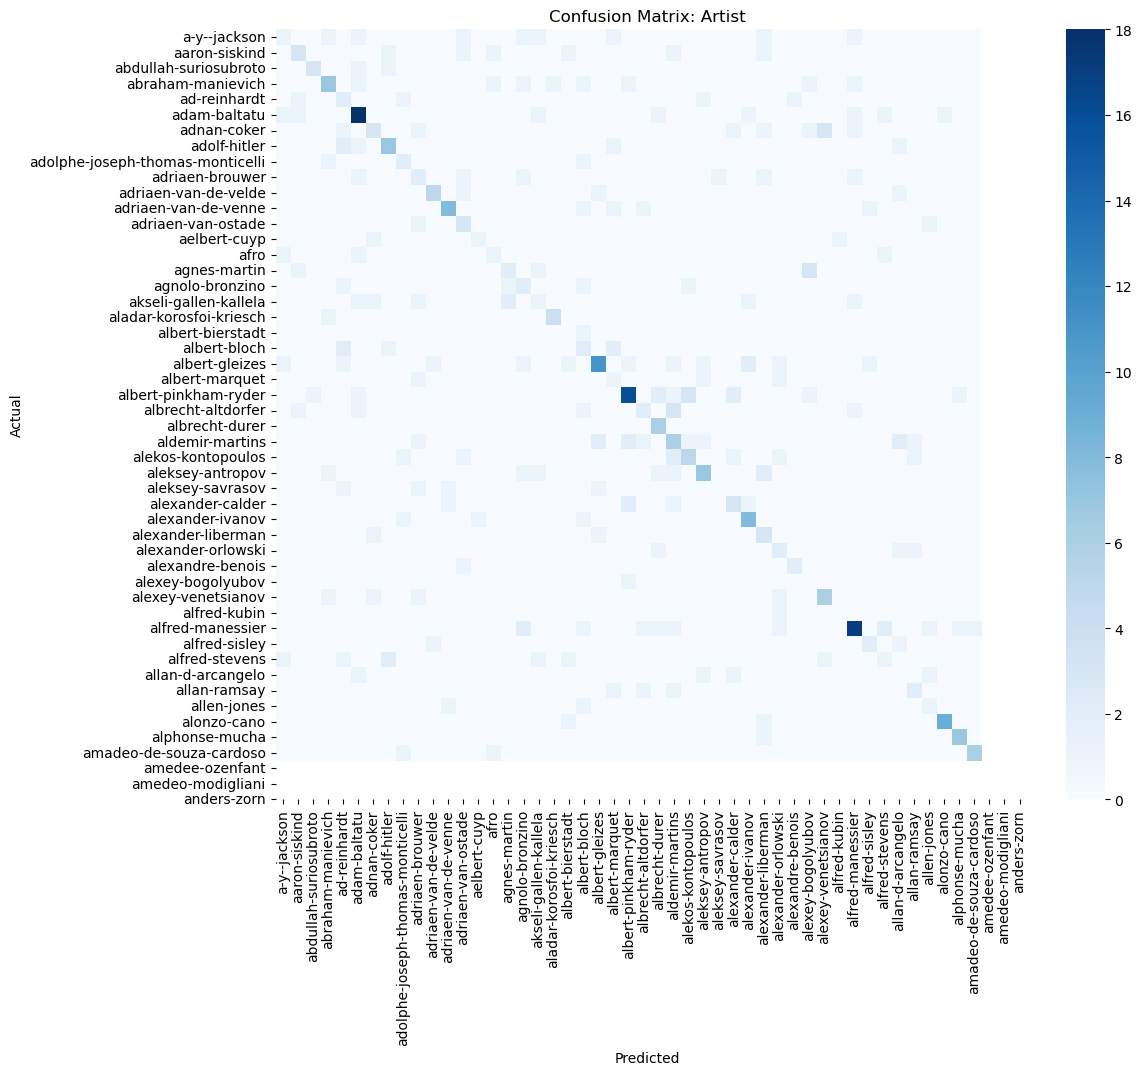

In [374]:
plot_confusion_matrix(y_true_artist_RS, y_pred_artist_RS, train_artist_classes[:50], "Artist")

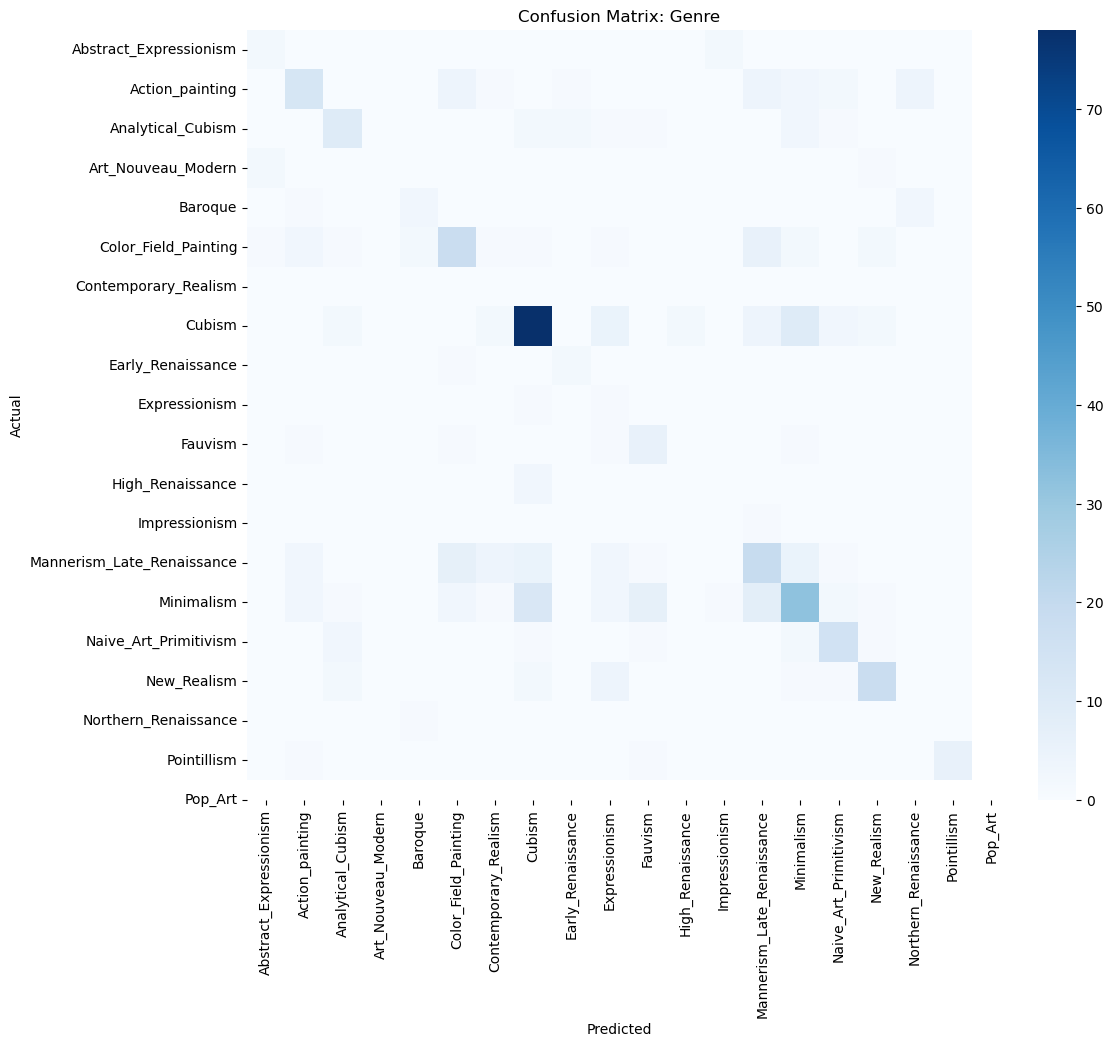

In [375]:
plot_confusion_matrix(y_true_genre_RS, y_pred_genre_RS, train_genre_classes[:20], "Genre")

In [379]:
predicted_genre_names_RS = [train_genre_classes[int(idx)] for idx in y_pred_genre_RS]
predicted_artist_names_RS = [train_artist_classes[int(idx)] for idx in y_pred_artist_RS]

In [380]:
genre_counter_RS = Counter(predicted_genre_names_RS)
artist_counter_RS = Counter(predicted_artist_names_RS)

In [381]:
top_genres_df_RS = pd.DataFrame(genre_counter_RS.most_common(10), columns=["Genre", "Count"])
top_artists_df_RS = pd.DataFrame(artist_counter_RS.most_common(10), columns=["Artist", "Count"])

In [382]:
print("Top 10 Predicted Genres:")
print(top_genres_df_RS)
print("\nTop 10 Predicted Artists:")
print(top_artists_df_RS)

Top 10 Predicted Genres:
                   Genre  Count
0          Impressionism    105
1                Realism     59
2     Post_Impressionism     42
3          Expressionism     34
4            Romanticism     25
5              Symbolism     25
6     Art_Nouveau_Modern     25
7  Naive_Art_Primitivism     19
8                Baroque     19
9   Northern_Renaissance     17

Top 10 Predicted Artists:
                 Artist  Count
0          adam-baltatu     28
1      alfred-manessier     24
2  albert-pinkham-ryder     23
3       aldemir-martins     18
4        albert-gleizes     16
5      alexander-ivanov     13
6      aleksey-antropov     12
7          adolf-hitler     12
8        albrecht-durer     12
9     abraham-manievich     12


In [394]:
with open(os.path.join(save_dir, "genre_classes.json"), "w") as f:
    json.dump(train_genre_classes, f)

with open(os.path.join(save_dir, "artist_classes.json"), "w") as f:
    json.dump(train_artist_classes, f)

In [396]:
model.save(os.path.join(save_dir, "efficientnetb3_model.keras"))
